In [2]:
!pip install nnAudio

In [3]:
from google.colab import drive
drive.mount('/midi')

Mounted at /midi


In [4]:
ls /midi/MyDrive/midi

 colab_unet_20.pt
 colab_unet_model.pth
 GM_long.pth
'Inline Model from Working Version-V3_reaper_midi error_drop_05_nosig_best.pth'
 __pycache__/
 reaper_audio_3.wav
 reaper_audio.wav
 reaper_GM_audio.wav
 reaper_GM_midi_processed.csv
 reaper_midi_GM.csv
 reaper_midi_loop_2_cym.csv
 reaper_midi_loop_3.csv
 reaper_midi_loop.csv
 reaper_midi_loop_processed_3.csv
 reaper_midi_loop_processed.csv
 robert.py


# New Section

# New Section

In [5]:
import os
import numpy as np
import librosa
import torch
from nnAudio import Spectrogram
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import sys
#sys.path.append('/midi/MyDrive/midi/')
import robert



/usr/local/lib/python3.10/dist-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [6]:
# Create Y data
# Y Step 1
# Create list_of_midi_arrays
# Time-scales and truncates midi arrays.
# Inserts empty arrays if no midi data within loop_time
# Contains three columns: note, loop_time, vel
# Change 832 -> 862. Need to change?

def get_list_of_midi_arrays(input_file_path, output_file_path, width=862, note_space=1, sec=2.5, new_loop_time=832):
    list_of_midi_arrays, num_slices = robert.process_midi_file(input_file_path, output_file_path,
                                                                width=width, note_space=note_space, sec=sec, new_loop_time=new_loop_time)
    return list_of_midi_arrays, num_slices

# Usage
input_file_path = '/midi/MyDrive/midi/reaper_midi_GM.csv'
output_file_path = '/midi/MyDrive/midi/reaper_GM_midi_processed.csv'
list_of_midi_arrays, num_slices = get_list_of_midi_arrays(input_file_path, output_file_path, width=862, note_space=1, sec=2.5, new_loop_time=832)
list_of_midi_arrays[0].shape, num_slices#, list_of_midi_arrays[40]

4800.0


((3, 3), 13680)

In [7]:
# Y Step 2
# Insert midi data into (127, 832) np arrays.
# Create list of arrays: 'list_of_processed_midi'

def process_list_of_midi_arrays(list_of_midi_arrays):
    list_of_processed_midi = []

    for idx, midi_array in enumerate(list_of_midi_arrays):
        processed_midi = np.zeros((127, 832))

        for row in midi_array:
            drum_id = int(row[0])     # assuming row[0] contains the drum ID (0 to 126)
            time_slice_idx = int(row[1])  # assuming row[1] contains the time slice index (0 to 831)
            velocity = row[2]         # assuming row[2] contains the velocity

            processed_midi[drum_id, time_slice_idx] = velocity

        list_of_processed_midi.append(processed_midi)

    return list_of_processed_midi

list_of_processed_midi = process_list_of_midi_arrays(list_of_midi_arrays)
#print(list_of_processed_midi[1].shape)

In [8]:
# Dataset for X, Y.

class AudioSliceDataset(Dataset):
    def __init__(self, audio_path, midi_data, slice_len_sec, sr=44100):
        self.audio, _ = librosa.load(audio_path, sr=sr)
        self.slice_len = int(slice_len_sec * sr)  # Length of slice in samples
        self.slices = self._slice_audio()
        self.midi_data = midi_data  # Processed MIDI data

    def _slice_audio(self):
        num_slices = len(self.audio) // self.slice_len
        return [self.audio[i * self.slice_len:(i + 1) * self.slice_len] for i in range(num_slices)]

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        audio_slice = torch.from_numpy(self.slices[idx]).float().to(device)  # Removed .to(device)
        midi_slice = torch.from_numpy(self.midi_data[idx]).float().to(device)  # Removed .to(device)
        midi_slice /= 127
        return audio_slice, midi_slice

"""# Now you can use this dataloader in your training loop:
for batch in dataloader:
    # Assuming your model and data are on the same device
    output = model(batch)
    # continue with your training...
"""

'# Now you can use this dataloader in your training loop:\nfor batch in dataloader:\n    # Assuming your model and data are on the same device\n    output = model(batch)\n    # continue with your training...\n'

In [9]:
"""
x1.shape:  torch.Size([1, 110250])
Output shape: torch.Size([1, 127, 832])

"""

class DrumClassifier(nn.Module):
    def __init__(self):
        super(DrumClassifier, self).__init__()

        # Initialize the STFT layer using nnAudio
        self.spec_layer = Spectrogram.STFT(n_fft=2048, hop_length=128, win_length=2048,
                                      trainable=True, window='hann', output_format='Magnitude')

        self.conv1 = nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

        self.deconv1 = nn.ConvTranspose1d(128, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose1d(256, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose1d(512, 127, kernel_size=3, stride=2, padding=1, output_padding=1)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #print("x1.shape: ", x.shape)

        # Apply spectrogram to input
        x = self.spec_layer(x)
        x = x[:, :1024, :832]
        # print("x2.shape: ", x.shape)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        #x = self.sigmoid(x)
        return x


In [10]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split

# Set your device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 16
num_epochs = 150
learning_rate = 1e-4

# Initialize the model, loss function, and optimizer
model = DrumClassifier().to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

audio_path = '/midi/MyDrive/midi/reaper_GM_audio.wav'
list_of_processed_midi = process_list_of_midi_arrays(list_of_midi_arrays)
dataset = AudioSliceDataset(audio_path, list_of_processed_midi, slice_len_sec=2.5)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Get the first batch of data
first_batch = next(iter(dataloader))

# Extract the X and Y data
x_data, y_data = first_batch

# Move the data to the GPU (if available)
x_data = x_data.to(device)
y_data = y_data.to(device)

# Print the shape of the X and Y data
print("X shape:", x_data.shape)
print("Y shape:", y_data.shape)


# Calculate the lengths of the training and test sets (80/20 split)
train_len = int(len(dataset) * 0.8)
test_len = len(dataset) - train_len

# Split the dataset into training and test sets
train_set, test_set = random_split(dataset, [train_len, test_len])
print("train_len: ", train_len)

# Create data loaders for the training and test sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)


STFT kernels created, time used = 0.1332 seconds
X shape: torch.Size([32, 110250])
Y shape: torch.Size([32, 127, 832])
train_len:  10944


In [ ]:
# Train the model
# Training loop with loss and accuracy tracking
# Train the model

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

clip_value = 0.5  # You can change this value depending on your needs

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_train_loss = 0.0
    num_correct_train = 0
    num_samples_train = 0

    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()

        epoch_train_loss += loss.item()

        # Calculate accuracy
        predicted = (outputs > 0.5).float()
        num_correct_train += (predicted == targets).sum().item()
        num_samples_train += targets.numel()

    avg_epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_accuracy = num_correct_train / num_samples_train

    train_losses.append(avg_epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)


    # Testing
    model.eval()
    epoch_test_loss = 0.0
    num_correct_test = 0
    num_samples_test = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            epoch_test_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            num_correct_test += (predicted == targets).sum().item()
            num_samples_test += targets.numel()

    avg_epoch_test_loss = epoch_test_loss / len(test_loader)
    epoch_test_accuracy = num_correct_test / num_samples_test

    # Update the learning rate based on the validation loss
    scheduler.step(avg_epoch_test_loss)

    test_losses.append(avg_epoch_test_loss)
    test_accuracies.append(epoch_test_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_epoch_train_loss:.4e}, Train Accuracy: {epoch_train_accuracy:.4e}, Test Loss: {avg_epoch_test_loss:.4e}, Test Accuracy: {epoch_test_accuracy:.4e}")


Epoch [1/150], Train Loss: 9.2925e-05, Train Accuracy: 9.9983e-01, Test Loss: 6.3556e-05, Test Accuracy: 9.9983e-01
Epoch [2/150], Train Loss: 5.5585e-05, Train Accuracy: 9.9983e-01, Test Loss: 5.1200e-05, Test Accuracy: 9.9983e-01
Epoch [3/150], Train Loss: 4.8661e-05, Train Accuracy: 9.9983e-01, Test Loss: 4.7388e-05, Test Accuracy: 9.9983e-01
Epoch [4/150], Train Loss: 4.3846e-05, Train Accuracy: 9.9983e-01, Test Loss: 4.1668e-05, Test Accuracy: 9.9983e-01
Epoch [5/150], Train Loss: 3.8566e-05, Train Accuracy: 9.9983e-01, Test Loss: 3.7323e-05, Test Accuracy: 9.9983e-01
Epoch [6/150], Train Loss: 3.3988e-05, Train Accuracy: 9.9983e-01, Test Loss: 3.2736e-05, Test Accuracy: 9.9983e-01
Epoch [7/150], Train Loss: 3.0168e-05, Train Accuracy: 9.9983e-01, Test Loss: 3.0081e-05, Test Accuracy: 9.9983e-01
Epoch [8/150], Train Loss: 2.7347e-05, Train Accuracy: 9.9983e-01, Test Loss: 2.7352e-05, Test Accuracy: 9.9983e-01
Epoch [9/150], Train Loss: 2.4878e-05, Train Accuracy: 9.9984e-01, Test 

In [ ]:
"""
Previous calculations (for reference)
Epoch [1/150], Train Loss: 9.6550e-05, Train Accuracy: 9.9985e-01, Test Loss: 6.8493e-05, Test Accuracy: 9.9985e-01
Epoch [2/150], Train Loss: 6.2372e-05, Train Accuracy: 9.9985e-01, Test Loss: 5.7504e-05, Test Accuracy: 9.9985e-01
Epoch [3/150], Train Loss: 5.6080e-05, Train Accuracy: 9.9985e-01, Test Loss: 5.4564e-05, Test Accuracy: 9.9985e-01
Epoch [4/150], Train Loss: 5.3825e-05, Train Accuracy: 9.9985e-01, Test Loss: 5.2685e-05, Test Accuracy: 9.9985e-01
Epoch [5/150], Train Loss: 5.1890e-05, Train Accuracy: 9.9985e-01, Test Loss: 5.1442e-05, Test Accuracy: 9.9985e-01
Epoch [6/150], Train Loss: 5.0032e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.9427e-05, Test Accuracy: 9.9986e-01
Epoch [7/150], Train Loss: 4.8292e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.8010e-05, Test Accuracy: 9.9986e-01
Epoch [8/150], Train Loss: 4.6743e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.6832e-05, Test Accuracy: 9.9986e-01
Epoch [9/150], Train Loss: 4.5315e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.5950e-05, Test Accuracy: 9.9986e-01
Epoch [10/150], Train Loss: 4.4142e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.5145e-05, Test Accuracy: 9.9986e-01
Epoch [11/150], Train Loss: 4.2904e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.5094e-05, Test Accuracy: 9.9986e-01
Epoch [12/150], Train Loss: 4.1798e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.3660e-05, Test Accuracy: 9.9986e-01
Epoch [13/150], Train Loss: 4.0616e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.3405e-05, Test Accuracy: 9.9986e-01
Epoch [14/150], Train Loss: 3.9574e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.3165e-05, Test Accuracy: 9.9985e-01
Epoch [15/150], Train Loss: 3.8620e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.2157e-05, Test Accuracy: 9.9986e-01
Epoch [16/150], Train Loss: 3.7576e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.1611e-05, Test Accuracy: 9.9986e-01
Epoch [17/150], Train Loss: 3.6520e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.1262e-05, Test Accuracy: 9.9986e-01
Epoch [18/150], Train Loss: 3.5375e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.0302e-05, Test Accuracy: 9.9986e-01
Epoch [19/150], Train Loss: 3.4478e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.0089e-05, Test Accuracy: 9.9986e-01
Epoch [20/150], Train Loss: 3.3428e-05, Train Accuracy: 9.9986e-01, Test Loss: 3.9610e-05, Test Accuracy: 9.9986e-01
Epoch [21/150], Train Loss: 3.2375e-05, Train Accuracy: 9.9986e-01, Test Loss: 3.9052e-05, Test Accuracy: 9.9985e-01
Epoch [22/150], Train Loss: 3.1362e-05, Train Accuracy: 9.9986e-01, Test Loss: 3.8028e-05, Test Accuracy: 9.9986e-01
Epoch [23/150], Train Loss: 3.0484e-05, Train Accuracy: 9.9986e-01, Test Loss: 3.7585e-05, Test Accuracy: 9.9986e-01
Epoch [24/150], Train Loss: 2.9513e-05, Train Accuracy: 9.9986e-01, Test Loss: 3.7242e-05, Test Accuracy: 9.9986e-01
Epoch [25/150], Train Loss: 2.8593e-05, Train Accuracy: 9.9986e-01, Test Loss: 3.6637e-05, Test Accuracy: 9.9986e-01
Epoch [26/150], Train Loss: 2.7806e-05, Train Accuracy: 9.9986e-01, Test Loss: 3.6507e-05, Test Accuracy: 9.9986e-01
Epoch [27/150], Train Loss: 2.6880e-05, Train Accuracy: 9.9986e-01, Test Loss: 3.5971e-05, Test Accuracy: 9.9986e-01
Epoch [28/150], Train Loss: 2.6044e-05, Train Accuracy: 9.9986e-01, Test Loss: 3.6201e-05, Test Accuracy: 9.9985e-01
Epoch [29/150], Train Loss: 2.5260e-05, Train Accuracy: 9.9986e-01, Test Loss: 3.5567e-05, Test Accuracy: 9.9986e-01
Epoch [30/150], Train Loss: 2.4562e-05, Train Accuracy: 9.9986e-01, Test Loss: 3.5129e-05, Test Accuracy: 9.9986e-01
Epoch [31/150], Train Loss: 2.3797e-05, Train Accuracy: 9.9986e-01, Test Loss: 3.4897e-05, Test Accuracy: 9.9986e-01
Epoch [32/150], Train Loss: 2.3170e-05, Train Accuracy: 9.9986e-01, Test Loss: 3.4570e-05, Test Accuracy: 9.9986e-01
Epoch [33/150], Train Loss: 2.2472e-05, Train Accuracy: 9.9986e-01, Test Loss: 3.4141e-05, Test Accuracy: 9.9986e-01
Epoch [34/150], Train Loss: 2.1862e-05, Train Accuracy: 9.9986e-01, Test Loss: 3.4036e-05, Test Accuracy: 9.9986e-01
Epoch [35/150], Train Loss: 2.1338e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.3829e-05, Test Accuracy: 9.9986e-01
Epoch [36/150], Train Loss: 2.0743e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.3495e-05, Test Accuracy: 9.9986e-01
Epoch [37/150], Train Loss: 2.0184e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.3897e-05, Test Accuracy: 9.9985e-01
Epoch [38/150], Train Loss: 1.9713e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.3118e-05, Test Accuracy: 9.9986e-01
Epoch [39/150], Train Loss: 1.9191e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.3106e-05, Test Accuracy: 9.9986e-01
Epoch [40/150], Train Loss: 1.8873e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.2706e-05, Test Accuracy: 9.9986e-01
Epoch [41/150], Train Loss: 1.8462e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.3611e-05, Test Accuracy: 9.9985e-01
Epoch [42/150], Train Loss: 1.8072e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.2320e-05, Test Accuracy: 9.9986e-01
Epoch [43/150], Train Loss: 1.7508e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.2661e-05, Test Accuracy: 9.9986e-01
Epoch [44/150], Train Loss: 1.7336e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.2449e-05, Test Accuracy: 9.9986e-01
Epoch [45/150], Train Loss: 1.7115e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.2052e-05, Test Accuracy: 9.9986e-01
Epoch [46/150], Train Loss: 1.6764e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1909e-05, Test Accuracy: 9.9986e-01
Epoch [47/150], Train Loss: 1.6379e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.2104e-05, Test Accuracy: 9.9986e-01
Epoch [48/150], Train Loss: 1.6203e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.2198e-05, Test Accuracy: 9.9986e-01
Epoch [49/150], Train Loss: 1.5852e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1965e-05, Test Accuracy: 9.9986e-01
Epoch [50/150], Train Loss: 1.5773e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1726e-05, Test Accuracy: 9.9986e-01
Epoch [51/150], Train Loss: 1.5542e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.2133e-05, Test Accuracy: 9.9985e-01
Epoch [52/150], Train Loss: 1.5135e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.2366e-05, Test Accuracy: 9.9985e-01
Epoch [53/150], Train Loss: 1.5042e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1448e-05, Test Accuracy: 9.9986e-01
Epoch [54/150], Train Loss: 1.4921e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1801e-05, Test Accuracy: 9.9985e-01
Epoch [55/150], Train Loss: 1.4630e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.2520e-05, Test Accuracy: 9.9985e-01
Epoch [56/150], Train Loss: 1.4566e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.2106e-05, Test Accuracy: 9.9985e-01
Epoch [57/150], Train Loss: 1.4428e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1513e-05, Test Accuracy: 9.9986e-01
Epoch [58/150], Train Loss: 1.4053e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1165e-05, Test Accuracy: 9.9986e-01
Epoch [59/150], Train Loss: 1.4010e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1603e-05, Test Accuracy: 9.9985e-01
Epoch [60/150], Train Loss: 1.3802e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.2295e-05, Test Accuracy: 9.9985e-01
Epoch [61/150], Train Loss: 1.3632e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1812e-05, Test Accuracy: 9.9985e-01
Epoch [62/150], Train Loss: 1.3638e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1058e-05, Test Accuracy: 9.9986e-01
Epoch [63/150], Train Loss: 1.3609e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1187e-05, Test Accuracy: 9.9985e-01
Epoch [64/150], Train Loss: 1.3380e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1848e-05, Test Accuracy: 9.9985e-01
Epoch [65/150], Train Loss: 1.3192e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1074e-05, Test Accuracy: 9.9986e-01
Epoch [66/150], Train Loss: 1.2995e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1184e-05, Test Accuracy: 9.9985e-01
Epoch [67/150], Train Loss: 1.3065e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1269e-05, Test Accuracy: 9.9985e-01
Epoch [68/150], Train Loss: 1.2793e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1186e-05, Test Accuracy: 9.9985e-01
Epoch [69/150], Train Loss: 1.2759e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1008e-05, Test Accuracy: 9.9985e-01
Epoch [70/150], Train Loss: 1.2680e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1468e-05, Test Accuracy: 9.9985e-01
Epoch [71/150], Train Loss: 1.2504e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0819e-05, Test Accuracy: 9.9985e-01
Epoch [72/150], Train Loss: 1.2496e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0984e-05, Test Accuracy: 9.9985e-01
Epoch [73/150], Train Loss: 1.2277e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0979e-05, Test Accuracy: 9.9985e-01
Epoch [74/150], Train Loss: 1.1938e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0573e-05, Test Accuracy: 9.9986e-01
Epoch [75/150], Train Loss: 1.1949e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1893e-05, Test Accuracy: 9.9985e-01
Epoch [76/150], Train Loss: 1.2084e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0808e-05, Test Accuracy: 9.9985e-01
Epoch [77/150], Train Loss: 1.2039e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1513e-05, Test Accuracy: 9.9985e-01
Epoch [78/150], Train Loss: 1.1896e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1652e-05, Test Accuracy: 9.9985e-01
Epoch [79/150], Train Loss: 1.1724e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1048e-05, Test Accuracy: 9.9985e-01
Epoch [80/150], Train Loss: 1.1613e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0953e-05, Test Accuracy: 9.9985e-01
Epoch [81/150], Train Loss: 1.1427e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0289e-05, Test Accuracy: 9.9986e-01
Epoch [82/150], Train Loss: 1.1335e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1204e-05, Test Accuracy: 9.9985e-01
Epoch [83/150], Train Loss: 1.1398e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0863e-05, Test Accuracy: 9.9985e-01
Epoch [84/150], Train Loss: 1.1593e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1026e-05, Test Accuracy: 9.9985e-01
Epoch [85/150], Train Loss: 1.1352e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0249e-05, Test Accuracy: 9.9985e-01
Epoch [86/150], Train Loss: 1.1031e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0276e-05, Test Accuracy: 9.9985e-01
Epoch [87/150], Train Loss: 1.0752e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0334e-05, Test Accuracy: 9.9985e-01
Epoch [88/150], Train Loss: 1.0747e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1036e-05, Test Accuracy: 9.9985e-01
Epoch [89/150], Train Loss: 1.1082e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0913e-05, Test Accuracy: 9.9985e-01
Epoch [90/150], Train Loss: 1.0770e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0715e-05, Test Accuracy: 9.9985e-01
Epoch [91/150], Train Loss: 1.0764e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0487e-05, Test Accuracy: 9.9985e-01
Epoch [92/150], Train Loss: 1.0494e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0697e-05, Test Accuracy: 9.9985e-01
Epoch [93/150], Train Loss: 1.0759e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0167e-05, Test Accuracy: 9.9985e-01
Epoch [94/150], Train Loss: 1.0523e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0660e-05, Test Accuracy: 9.9985e-01
Epoch [95/150], Train Loss: 1.0531e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0409e-05, Test Accuracy: 9.9985e-01
Epoch [96/150], Train Loss: 1.0200e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0406e-05, Test Accuracy: 9.9985e-01
Epoch [97/150], Train Loss: 1.0216e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0872e-05, Test Accuracy: 9.9985e-01
Epoch [98/150], Train Loss: 1.0382e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.1179e-05, Test Accuracy: 9.9985e-01
Epoch [99/150], Train Loss: 1.0310e-05, Train Accuracy: 9.9987e-01, Test Loss: 3.0603e-05, Test Accuracy: 9.9985e-01
Epoch [100/150], Train Loss: 9.9299e-06, Train Accuracy: 9.9987e-01, Test Loss: 3.0775e-05, Test Accuracy: 9.9985e-01
Epoch [101/150], Train Loss: 9.8963e-06, Train Accuracy: 9.9987e-01, Test Loss: 3.0091e-05, Test Accuracy: 9.9985e-01
Epoch [102/150], Train Loss: 9.7096e-06, Train Accuracy: 9.9987e-01, Test Loss: 3.0284e-05, Test Accuracy: 9.9985e-01
Epoch [103/150], Train Loss: 9.9809e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.9910e-05, Test Accuracy: 9.9985e-01
Epoch [104/150], Train Loss: 9.7808e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.9985e-05, Test Accuracy: 9.9985e-01
Epoch [105/150], Train Loss: 9.5589e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.9880e-05, Test Accuracy: 9.9985e-01
Epoch [106/150], Train Loss: 9.7276e-06, Train Accuracy: 9.9987e-01, Test Loss: 3.1151e-05, Test Accuracy: 9.9985e-01
Epoch [107/150], Train Loss: 9.9630e-06, Train Accuracy: 9.9987e-01, Test Loss: 3.0387e-05, Test Accuracy: 9.9985e-01
Epoch [108/150], Train Loss: 9.4476e-06, Train Accuracy: 9.9987e-01, Test Loss: 3.0546e-05, Test Accuracy: 9.9985e-01
Epoch [109/150], Train Loss: 9.2774e-06, Train Accuracy: 9.9987e-01, Test Loss: 3.0216e-05, Test Accuracy: 9.9985e-01
Epoch [110/150], Train Loss: 9.3271e-06, Train Accuracy: 9.9987e-01, Test Loss: 3.0126e-05, Test Accuracy: 9.9985e-01
Epoch [111/150], Train Loss: 9.3859e-06, Train Accuracy: 9.9987e-01, Test Loss: 3.1123e-05, Test Accuracy: 9.9985e-01
Epoch [112/150], Train Loss: 9.4747e-06, Train Accuracy: 9.9987e-01, Test Loss: 3.0524e-05, Test Accuracy: 9.9985e-01
Epoch [113/150], Train Loss: 9.1749e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.9941e-05, Test Accuracy: 9.9985e-01
Epoch [114/150], Train Loss: 9.0409e-06, Train Accuracy: 9.9987e-01, Test Loss: 3.0655e-05, Test Accuracy: 9.9985e-01
Epoch [115/150], Train Loss: 9.0128e-06, Train Accuracy: 9.9987e-01, Test Loss: 3.0173e-05, Test Accuracy: 9.9985e-01
Epoch 00116: reducing learning rate of group 0 to 1.0000e-05.
Epoch [116/150], Train Loss: 8.9710e-06, Train Accuracy: 9.9987e-01, Test Loss: 3.0280e-05, Test Accuracy: 9.9985e-01
Epoch [117/150], Train Loss: 8.2868e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.9146e-05, Test Accuracy: 9.9985e-01
Epoch [118/150], Train Loss: 8.1040e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.9180e-05, Test Accuracy: 9.9985e-01
Epoch [119/150], Train Loss: 8.0435e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.9027e-05, Test Accuracy: 9.9986e-01
Epoch [120/150], Train Loss: 7.9984e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.9020e-05, Test Accuracy: 9.9986e-01
Epoch [121/150], Train Loss: 7.9614e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8941e-05, Test Accuracy: 9.9986e-01
Epoch [122/150], Train Loss: 7.9307e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8988e-05, Test Accuracy: 9.9986e-01
Epoch [123/150], Train Loss: 7.9029e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8951e-05, Test Accuracy: 9.9986e-01
Epoch [124/150], Train Loss: 7.8779e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.9015e-05, Test Accuracy: 9.9986e-01
Epoch [125/150], Train Loss: 7.8529e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8921e-05, Test Accuracy: 9.9986e-01
Epoch [126/150], Train Loss: 7.8304e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8898e-05, Test Accuracy: 9.9986e-01
Epoch [127/150], Train Loss: 7.8073e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8947e-05, Test Accuracy: 9.9986e-01
Epoch [128/150], Train Loss: 7.7892e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8904e-05, Test Accuracy: 9.9986e-01
Epoch [129/150], Train Loss: 7.7676e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8983e-05, Test Accuracy: 9.9986e-01
Epoch [130/150], Train Loss: 7.7498e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.9002e-05, Test Accuracy: 9.9986e-01
Epoch [131/150], Train Loss: 7.7314e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8975e-05, Test Accuracy: 9.9986e-01
Epoch [132/150], Train Loss: 7.7144e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8941e-05, Test Accuracy: 9.9986e-01
Epoch [133/150], Train Loss: 7.6969e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8923e-05, Test Accuracy: 9.9986e-01
Epoch [134/150], Train Loss: 7.6802e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8950e-05, Test Accuracy: 9.9986e-01
Epoch [135/150], Train Loss: 7.6654e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.9012e-05, Test Accuracy: 9.9986e-01
Epoch [136/150], Train Loss: 7.6482e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8887e-05, Test Accuracy: 9.9986e-01
Epoch [137/150], Train Loss: 7.6323e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8977e-05, Test Accuracy: 9.9986e-01
Epoch [138/150], Train Loss: 7.6166e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8951e-05, Test Accuracy: 9.9986e-01
Epoch [139/150], Train Loss: 7.6028e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8961e-05, Test Accuracy: 9.9986e-01
Epoch [140/150], Train Loss: 7.5874e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8923e-05, Test Accuracy: 9.9986e-01
Epoch [141/150], Train Loss: 7.5728e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8916e-05, Test Accuracy: 9.9986e-01
Epoch [142/150], Train Loss: 7.5573e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8934e-05, Test Accuracy: 9.9986e-01
Epoch [143/150], Train Loss: 7.5444e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8884e-05, Test Accuracy: 9.9986e-01
Epoch [144/150], Train Loss: 7.5298e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8896e-05, Test Accuracy: 9.9986e-01
Epoch [145/150], Train Loss: 7.5164e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.9005e-05, Test Accuracy: 9.9986e-01
Epoch [146/150], Train Loss: 7.5020e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8941e-05, Test Accuracy: 9.9986e-01
Epoch [147/150], Train Loss: 7.4903e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8938e-05, Test Accuracy: 9.9986e-01
Epoch [148/150], Train Loss: 7.4772e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8941e-05, Test Accuracy: 9.9986e-01
Epoch [149/150], Train Loss: 7.4633e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8967e-05, Test Accuracy: 9.9986e-01
Epoch [150/150], Train Loss: 7.4500e-06, Train Accuracy: 9.9987e-01, Test Loss: 2.8918e-05, Test Accuracy: 9.9986e-01
"""

'\nPrevious calculations (for reference)\nEpoch [1/150], Train Loss: 9.6550e-05, Train Accuracy: 9.9985e-01, Test Loss: 6.8493e-05, Test Accuracy: 9.9985e-01\nEpoch [2/150], Train Loss: 6.2372e-05, Train Accuracy: 9.9985e-01, Test Loss: 5.7504e-05, Test Accuracy: 9.9985e-01\nEpoch [3/150], Train Loss: 5.6080e-05, Train Accuracy: 9.9985e-01, Test Loss: 5.4564e-05, Test Accuracy: 9.9985e-01\nEpoch [4/150], Train Loss: 5.3825e-05, Train Accuracy: 9.9985e-01, Test Loss: 5.2685e-05, Test Accuracy: 9.9985e-01\nEpoch [5/150], Train Loss: 5.1890e-05, Train Accuracy: 9.9985e-01, Test Loss: 5.1442e-05, Test Accuracy: 9.9985e-01\nEpoch [6/150], Train Loss: 5.0032e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.9427e-05, Test Accuracy: 9.9986e-01\nEpoch [7/150], Train Loss: 4.8292e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.8010e-05, Test Accuracy: 9.9986e-01\nEpoch [8/150], Train Loss: 4.6743e-05, Train Accuracy: 9.9986e-01, Test Loss: 4.6832e-05, Test Accuracy: 9.9986e-01\nEpoch [9/150], Train L

In [ ]:
"""
Epoch [1/25], Train Loss: 1.2842, Train Accuracy: 0.9915, Test Loss: 1.0495, Test Accuracy: 0.9891
Epoch [2/25], Train Loss: 1.0115, Train Accuracy: 0.9901, Test Loss: 0.9570, Test Accuracy: 0.9907
Epoch [3/25], Train Loss: 0.9582, Train Accuracy: 0.9919, Test Loss: 0.9331, Test Accuracy: 0.9928
Epoch [4/25], Train Loss: 0.9395, Train Accuracy: 0.9930, Test Loss: 0.9221, Test Accuracy: 0.9932
Epoch [5/25], Train Loss: 0.9275, Train Accuracy: 0.9936, Test Loss: 0.9120, Test Accuracy: 0.9936
Epoch [6/25], Train Loss: 0.9159, Train Accuracy: 0.9940, Test Loss: 0.9057, Test Accuracy: 0.9940
Epoch [7/25], Train Loss: 0.9041, Train Accuracy: 0.9942, Test Loss: 0.9057, Test Accuracy: 0.9942
Epoch [8/25], Train Loss: 0.8939, Train Accuracy: 0.9941, Test Loss: 0.9057, Test Accuracy: 0.9939
Epoch [9/25], Train Loss: 0.8825, Train Accuracy: 0.9942, Test Loss: 0.8934, Test Accuracy: 0.9946
Epoch [10/25], Train Loss: 0.8704, Train Accuracy: 0.9943, Test Loss: 0.8973, Test Accuracy: 0.9943
Epoch [11/25], Train Loss: 0.8589, Train Accuracy: 0.9944, Test Loss: 0.8936, Test Accuracy: 0.9940
Epoch [12/25], Train Loss: 0.8468, Train Accuracy: 0.9945, Test Loss: 0.8897, Test Accuracy: 0.9947
Epoch [13/25], Train Loss: 0.8375, Train Accuracy: 0.9948, Test Loss: 0.8844, Test Accuracy: 0.9947
Epoch [14/25], Train Loss: 0.8283, Train Accuracy: 0.9949, Test Loss: 0.8757, Test Accuracy: 0.9952
Epoch [15/25], Train Loss: 0.8203, Train Accuracy: 0.9950, Test Loss: 0.8778, Test Accuracy: 0.9949
Epoch [16/25], Train Loss: 0.8141, Train Accuracy: 0.9951, Test Loss: 0.8833, Test Accuracy: 0.9951
Epoch [17/25], Train Loss: 0.8061, Train Accuracy: 0.9952, Test Loss: 0.8756, Test Accuracy: 0.9953
Epoch [18/25], Train Loss: 0.7978, Train Accuracy: 0.9953, Test Loss: 0.8757, Test Accuracy: 0.9955
Epoch [19/25], Train Loss: 0.7915, Train Accuracy: 0.9953, Test Loss: 0.8671, Test Accuracy: 0.9956
Epoch [20/25], Train Loss: 0.7840, Train Accuracy: 0.9953, Test Loss: 0.8629, Test Accuracy: 0.9956
Epoch [21/25], Train Loss: 0.7778, Train Accuracy: 0.9954, Test Loss: 0.8631, Test Accuracy: 0.9956
Epoch [22/25], Train Loss: 0.7722, Train Accuracy: 0.9954, Test Loss: 0.8639, Test Accuracy: 0.9952
Epoch [23/25], Train Loss: 0.7666, Train Accuracy: 0.9953, Test Loss: 0.8576, Test Accuracy: 0.9958
Epoch [24/25], Train Loss: 0.7600, Train Accuracy: 0.9954, Test Loss: 0.8596, Test Accuracy: 0.9951
Epoch [25/25], Train Loss: 0.7540, Train Accuracy: 0.9954, Test Loss: 0.8565, Test Accuracy: 0.9955
"""

'\nEpoch [1/25], Train Loss: 1.2842, Train Accuracy: 0.9915, Test Loss: 1.0495, Test Accuracy: 0.9891\nEpoch [2/25], Train Loss: 1.0115, Train Accuracy: 0.9901, Test Loss: 0.9570, Test Accuracy: 0.9907\nEpoch [3/25], Train Loss: 0.9582, Train Accuracy: 0.9919, Test Loss: 0.9331, Test Accuracy: 0.9928\nEpoch [4/25], Train Loss: 0.9395, Train Accuracy: 0.9930, Test Loss: 0.9221, Test Accuracy: 0.9932\nEpoch [5/25], Train Loss: 0.9275, Train Accuracy: 0.9936, Test Loss: 0.9120, Test Accuracy: 0.9936\nEpoch [6/25], Train Loss: 0.9159, Train Accuracy: 0.9940, Test Loss: 0.9057, Test Accuracy: 0.9940\nEpoch [7/25], Train Loss: 0.9041, Train Accuracy: 0.9942, Test Loss: 0.9057, Test Accuracy: 0.9942\nEpoch [8/25], Train Loss: 0.8939, Train Accuracy: 0.9941, Test Loss: 0.9057, Test Accuracy: 0.9939\nEpoch [9/25], Train Loss: 0.8825, Train Accuracy: 0.9942, Test Loss: 0.8934, Test Accuracy: 0.9946\nEpoch [10/25], Train Loss: 0.8704, Train Accuracy: 0.9943, Test Loss: 0.8973, Test Accuracy: 0.99

In [ ]:
# Specify the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
#model = DrumClassifier().to(device)

# Load the saved weights into the model
#model.load_state_dict(torch.load('/midi/MyDrive/midi/drum_classifier_inline_model_3.pth', map_location=device))


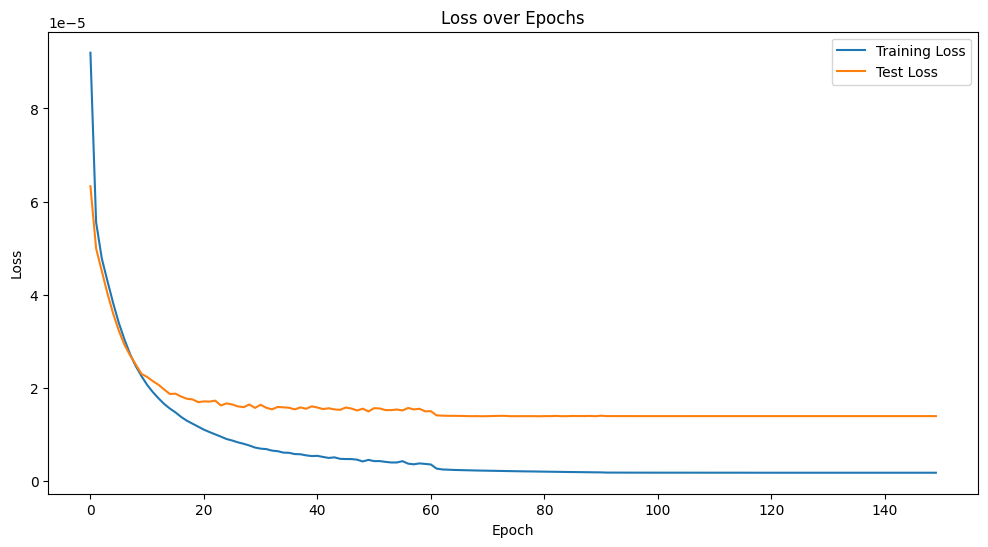

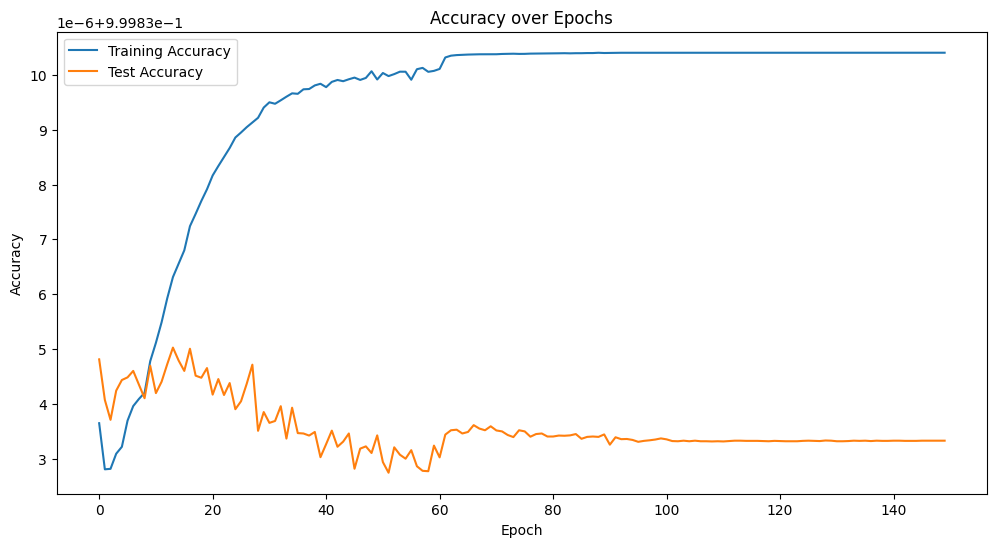

In [ ]:
# Plot training and test loss

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

# Plot training and test accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

In [ ]:
# Specify the path where you want to save your model
model_save_path = '/midi/MyDrive/midi/Inline Model from Working Version-V3_reaper_midi error_drop_05_nosig_best.pth'

# Save the model
torch.save(model.state_dict(), model_save_path)


In [ ]:
# Specify the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
#model = DrumClassifier().to(device)

# Load the saved weights into the model
#model.load_state_dict(torch.load('/midi/MyDrive/midi/Inline Model from Working Version-V3_reaper_midi error_drop_05_nosig_best.pth', map_location=device))


In [ ]:
# Print the values of 'output' and its shape.
# Set 'file_index' for printing spectrograms.
# The red code was used for saved STFTs. Now using inline. Can delete.

file_index = 9145  # this is the variable that you can change

x_slice_100 = dataset[file_index][0].unsqueeze(0).to(device)

# Pass the input tensor through the model
output = model(x_slice_100)

# Print the output shape and the output
print("Output shape:", output.shape)
print("Output:", output)

Output shape: torch.Size([1, 127, 832])
Output: tensor([[[ 2.0066e-04, -1.9435e-03,  8.8410e-05,  ...,  1.2655e-04,
          -6.1594e-05, -1.5386e-04],
         [ 1.0422e-04,  6.5514e-04,  4.5910e-04,  ...,  5.7157e-05,
          -5.1437e-06, -6.7910e-05],
         [-9.0666e-05,  1.0971e-05, -8.3939e-07,  ...,  1.9732e-05,
          -7.7934e-06, -1.9392e-07],
         ...,
         [ 1.9352e-05, -4.4606e-04,  1.2846e-03,  ...,  2.4203e-05,
           4.8373e-06,  1.4304e-04],
         [-8.5967e-05, -8.0932e-04,  5.4181e-04,  ..., -7.6541e-06,
           8.8409e-05, -3.0850e-05],
         [ 2.6245e-04, -2.5821e-04, -1.0884e-03,  ...,  1.8546e-05,
          -3.1876e-05,  2.9737e-05]]], device='cuda:0',
       grad_fn=<ConvolutionBackward0>)


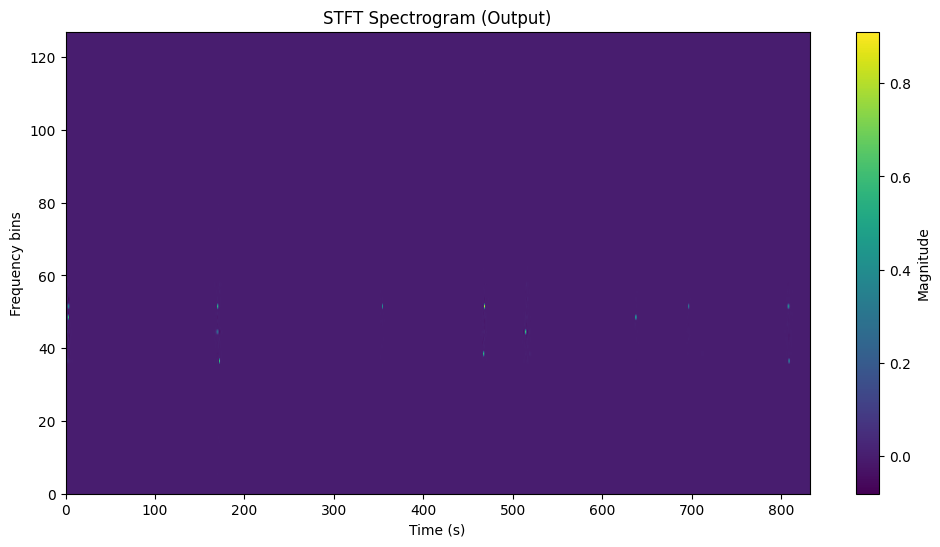

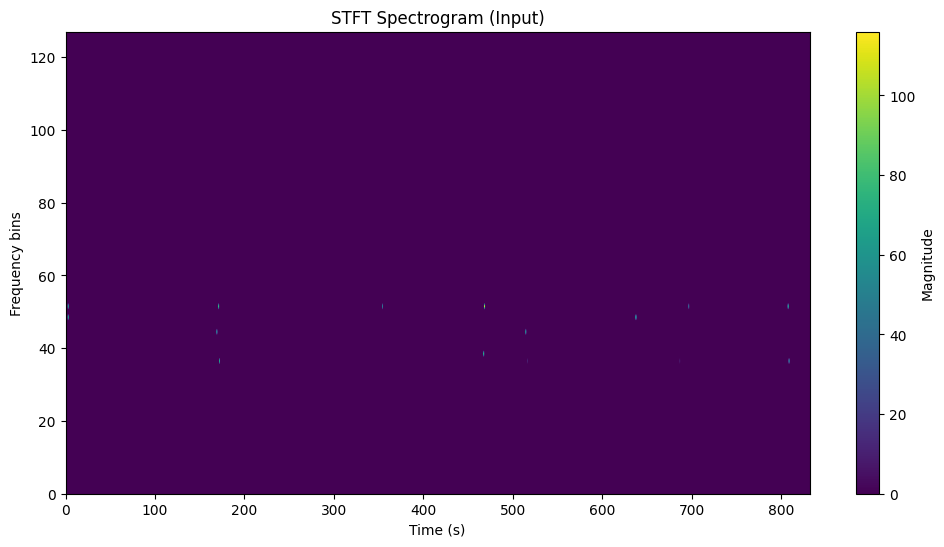

In [ ]:
# Plots the output of the STFT that was opened from disk. Tests the model.
# array_path = "D:/Python/common/midi/STFT/stft_spectrogram_0.npy"  # Replace the index with the desired slice

stft_check = output.detach().squeeze(0).cpu().numpy()

trunc_time = 2.5 * (832/862)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.imshow(stft_check, origin='lower', aspect='auto', cmap='viridis', extent=[0, 832, 0, 127])
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency bins')
plt.title('STFT Spectrogram (Output)')
plt.show()

#file_path = r"D:\Python\common\midi\MIDI\processed_midi_{0}.npy".format(file_index)
#spectrogram = np.load(file_path)
spectrogram = list_of_processed_midi[file_index]


trunc_time = 2.5 * (832/862)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.imshow(spectrogram, origin='lower', aspect='auto', cmap='viridis', extent=[0, 832, 0, 127])
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency bins')
plt.title('STFT Spectrogram (Input)')
plt.show()

In [ ]:
import numpy as np

# I'll generate a dummy 2D array for the example
spectrogram = list_of_processed_midi[file_index]

non_zero_values = []

# Iterate over the spectrogram
for i in range(spectrogram.shape[0]):
    for j in range(spectrogram.shape[1]):
        # If the value is non-zero
        if spectrogram[i][j] != 0:
            non_zero_values.append((i, j, spectrogram[i][j]))

# Sort the list by the y values (j indices)
non_zero_values.sort(key=lambda x: x[1])

# Print the sorted list
for val in non_zero_values:
    print(f"x: {val[0]}, y: {val[1]}, value: {val[2]}")


x: 36, y: 0, value: 12.0
x: 48, y: 2, value: 90.0
x: 51, y: 2, value: 80.0
x: 44, y: 168, value: 77.0
x: 51, y: 170, value: 93.0
x: 36, y: 171, value: 74.0
x: 51, y: 353, value: 51.0
x: 38, y: 466, value: 91.0
x: 51, y: 467, value: 116.0
x: 44, y: 513, value: 78.0
x: 36, y: 515, value: 11.0
x: 48, y: 636, value: 105.0
x: 36, y: 685, value: 10.0
x: 51, y: 695, value: 50.0
x: 51, y: 806, value: 99.0
x: 36, y: 807, value: 77.0


In [ ]:
# Get the indices where vel > 1

stft_check_127 = stft_check * 127
indices = np.argwhere(stft_check_127 > 9.5)

# Sort the indices by the y values (second column)
sorted_indices = indices[indices[:, 1].argsort()]

# Print the x, y, and vel values
for idx in sorted_indices:
    x, y = idx
    vel = int(stft_check_127[x, y])
    print(f"x: {x}, y: {y}, vel: {vel}")
type(stft_check_127)

x: 48, y: 2, vel: 111
x: 51, y: 2, vel: 62
x: 51, y: 3, vel: 22
x: 44, y: 168, vel: 18
x: 44, y: 169, vel: 39
x: 51, y: 169, vel: 98
x: 36, y: 171, vel: 83
x: 51, y: 353, vel: 56
x: 38, y: 466, vel: 91
x: 51, y: 467, vel: 115
x: 44, y: 512, vel: 14
x: 44, y: 513, vel: 107
x: 48, y: 636, vel: 105
x: 51, y: 695, vel: 53
x: 51, y: 806, vel: 66
x: 36, y: 807, vel: 73
x: 51, y: 807, vel: 31


numpy.ndarray

In [22]:
import sys

print("Python version:")
print(sys.version)

print("\nPython info:")
print(sys.version_info)

print("\nJupyter Notebook version:")
import notebook
print(notebook.__version__)

print("\nIPython version:")
import IPython
print(IPython.__version__)

print("\nNumPy version:")
import numpy as np
print(np.__version__)

print("\nPandas version:")
import pandas as pd
print(pd.__version__)

print("\nMatplotlib version:")
import matplotlib
print(matplotlib.__version__)

print("\nSeaborn version:")
import seaborn as sns
print(sns.__version__)

print("\nScikit-Learn version:")
import sklearn
print(sklearn.__version__)

print("\nPyTorch version:")
import torch
print(torch.__version__)

print("\nscipy version:")
import scipy
print(scipy.__version__)

print("\njoblib version:")
import joblib
print(joblib.__version__)

print("\nlibrosa version:")
import librosa
print(librosa.__version__)

print("\nnnAudioversion:")
import nnAudio
print(nnAudio.__version__)

import torch
cuda_version = torch.version.cuda if torch.cuda.is_available() else "No CUDA support"
print(f"\nCUDA Version: {cuda_version}")

Python version:
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

Python info:
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)

Jupyter Notebook version:
6.5.5

IPython version:
7.34.0

NumPy version:
1.23.5

Pandas version:
1.5.3

Matplotlib version:
3.7.1

Seaborn version:
0.12.2

Scikit-Learn version:
1.2.2

PyTorch version:
2.1.0+cu121

scipy version:
1.11.4

joblib version:
1.3.2

librosa version:
0.10.1

nnAudioversion:
0.3.2

CUDA Version: 12.1
